# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding Project** 
***

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---
[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

Libraries Include


In [1]:
import os
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Camera Calibration

#### 1. Computation of the camera matrix and distortion coefficients. 

Modern day cameras are designed to capture a lot of light rays in a small area in order to get a high quality pictures with a small physical piece of lense. In order to do this, camera lenses are designed to have curvatures which introduce radial and tangential distortion in the obtained image.

In order to get a more realistic 2D image out of the obtained image, camera calibration is needed. Camera calibration consists of using a known object (in most cases a chessboard) with known lengths and dimensions. These relate to the object points. Now the camera is used to obtain the image points which will have the distortion effects in them. These image points and object points are then computed together to obtain the camera matrix and the distortion coefficients using open CV library cv2.calibrateCamera()



The following code describes undistort function which shall read the image and undistort after calibrating the camera from the image (this code shall be used as a part of the pipeline in the later stages).

In [2]:
def undistort(image, plot):
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if plot == 1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Raw Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    return undist

#### Rubric Camera Calibration: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


The following code address the camera calibration using a 9x6 chessboard corner sides.


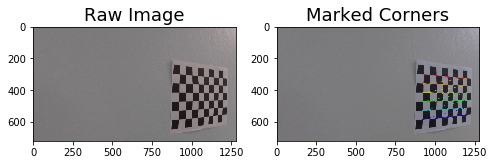

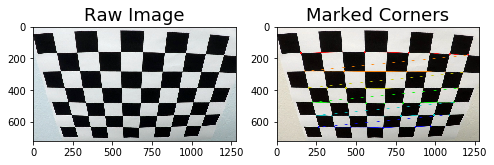

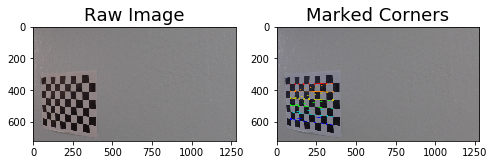

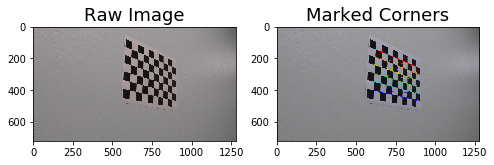

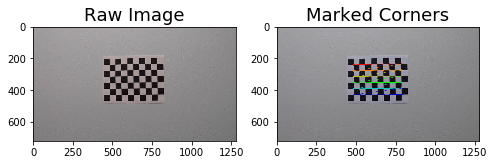

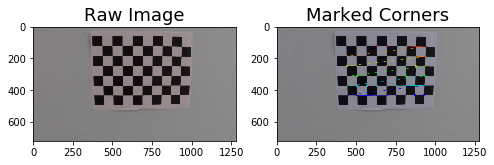

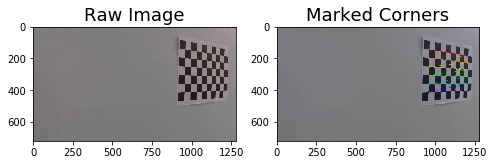

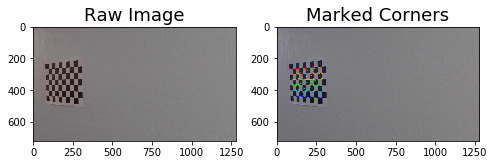

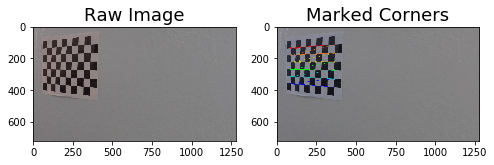

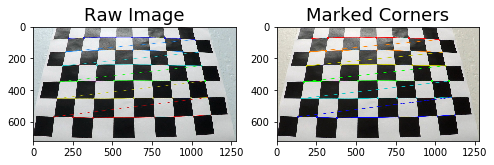

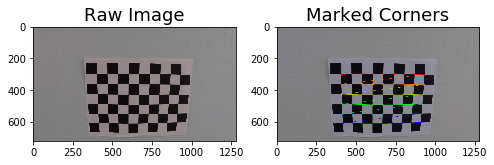

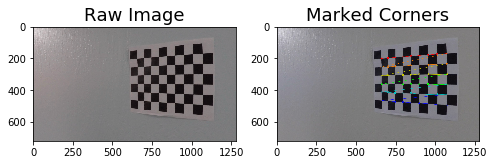

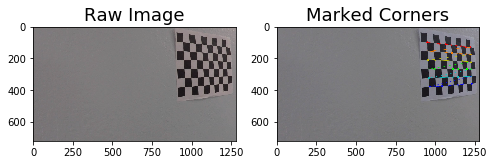

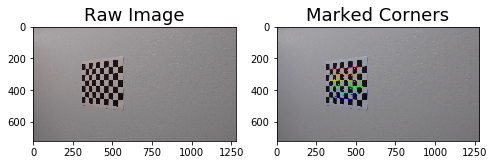

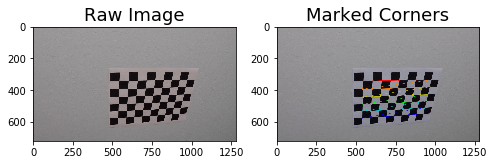

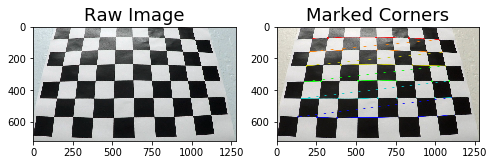

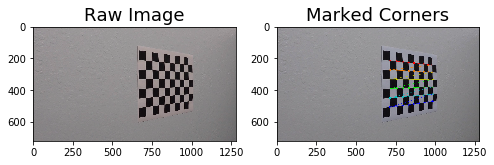

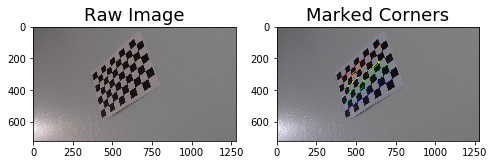

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')
# prepare object points
objpoints=[]
imgpoints =[]
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y
# define object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 
#Camera_Calibration
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Raw Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Marked Corners', fontsize=18)

### Pipeline (test images) - 

#### 2. Correcting for distortion effects after calibration of the camera image.

After obtaining the camera matrix and the coefficients which in lay man terms basically tell us the relation between the image obtained and the real world 2D space, the images obtained by a camera can then be corrected for distortion effects.

This is done by cv2.undistort function which uses the calculated camera matrix and distortion coefficients and outputs a corrected/ undistorted image.

The following code is calling the undistort function which was described previously and the results are as follows:-



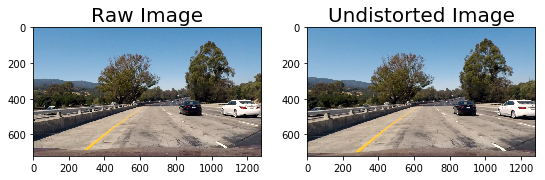

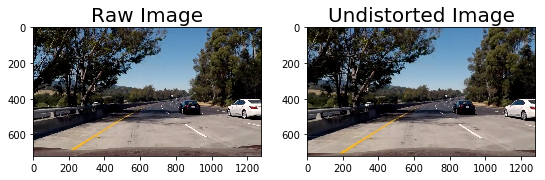

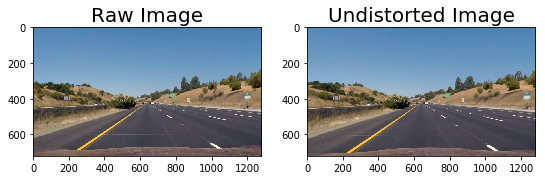

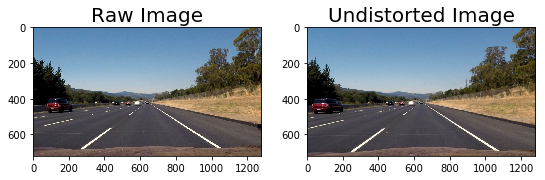

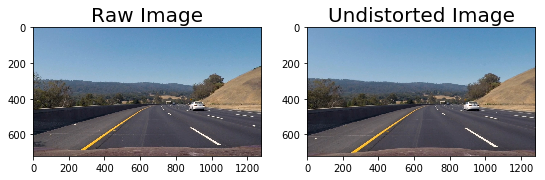

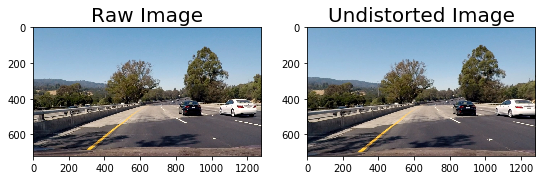

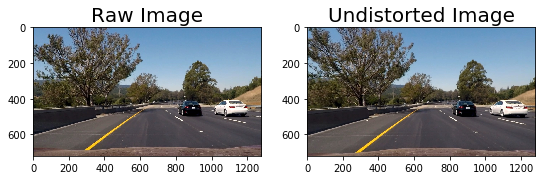

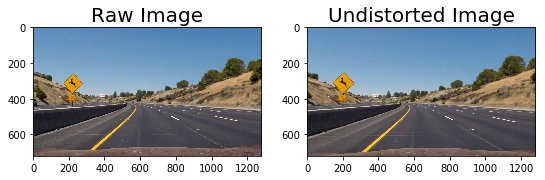

In [4]:
test_images = glob.glob('test_images/*.jpg')
for image in test_images:
    undistort(image,1)

### Perspective Transform 


#### 4. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `perspective()` which is described below. The `warper()` function takes as inputs an image (`img`) and (`plot argument`) which basically tells the function to plot or just return the warped image and the respective warp and unwarp matrices. 

This resulted in the following source and destination points:




| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |


I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In contrast to the rubic and the goals, I took a different approach to this problem. I prefer doing a perspective transform to the image and then applying the color and gradient thresholds. The reason behind this is to make sure first the maximum number of lanes are captured from the image. In my personal opinion, working with undistorted raw images work better than the gradient applied images. Hence I am going to perform a perspective transform to these undistorted images next.

The perspective transform requires the developer to select a set of 4 points (which define a quadrilateral) in the undistorted image and select a new coordinates for the same 4 points in the new image. This quadrilateral gets warped into the new image with the defined points. This is done by using the open CV function cv2.warpPerspective and getPerspectiveTransform. The former function applies the transformation matrices obtained by the latter function.

Following is the code for the perspective transform:-

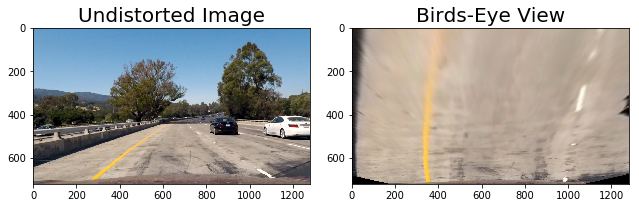

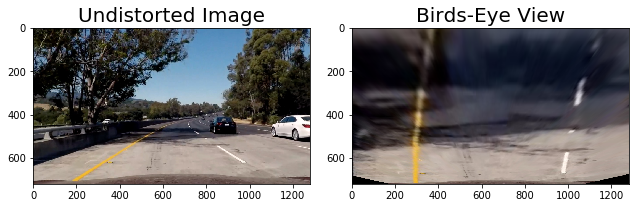

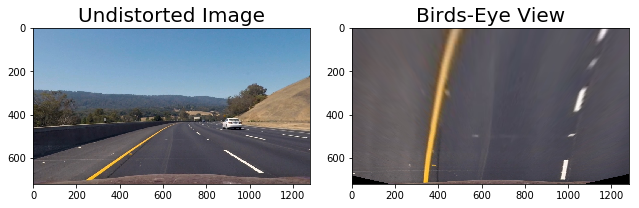

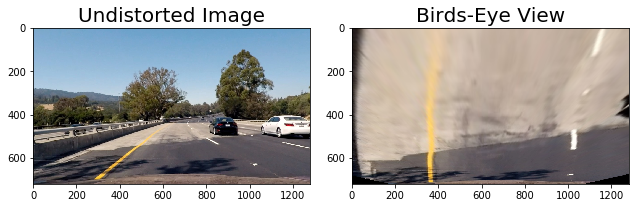

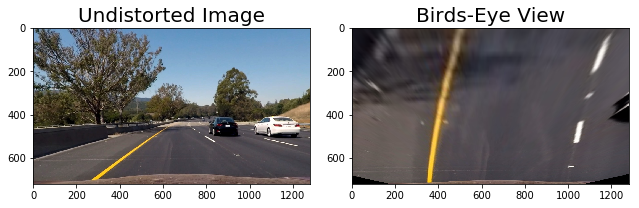

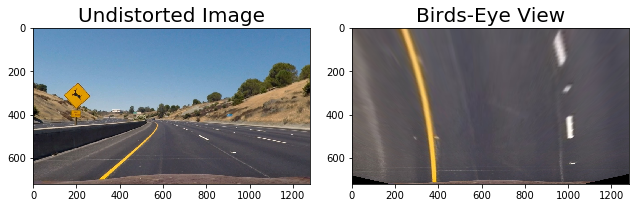

In [5]:
def perspective(img, plot):
    undistort_img = undistort(img, 0)
    img_size = (undistort_img.shape[1], undistort_img.shape[0])     
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])  
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    perspective = cv2.warpPerspective(undistort_img, M, img_size, flags=cv2.INTER_LINEAR)
    #warped= undistorted
    if plot == 1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undistort_img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(perspective, cv2.COLOR_BGR2RGB))
        ax2.set_title('Birds-Eye View', fontsize=20)

    return perspective,M,Minv

images = glob.glob('test_images/test*.jpg')
for image in images:
    perspective(image,1)

#### 3. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

After performing the perspective transform, we can apply different color gradients to the perspective images in order to get the binary picture of lane pixels. This process is a more subjective problem as it requires to visualize each of the color channel of an image and subjectively discern whether the lanes can be accurately captured by a color channel or not.



The following code is a part of the image processing pipeline which basically breaks any input image to various HLS, LUV, LAB channels and combines them based on their each individual thresholds. It is always great to have multiple types of channels configured as different channels can catch different conditions and colors which helps makes this algorithm robust. With some experimentation and visualizations, 

I found out that the l channel of LUV color space and the b channel of the LAB color space and s channel of the HLS color space were the most effective.

-The S Channel from the HLS color space with min threshold and max threshold of 90 and 255 respectively was able to identify both yellow and white lanes but was not robust to shadows on the road.

-The L Channel from the LUV color space with min threshold and max threshold of 220 and 255 respectively was very robust to white lanes but was poor on detecting the yellow lanes.

-The B channel from the Lab color space, with min threshold and max threshold of 150 and 210 respectively, was robust to yellow lines but poor on the white lines.


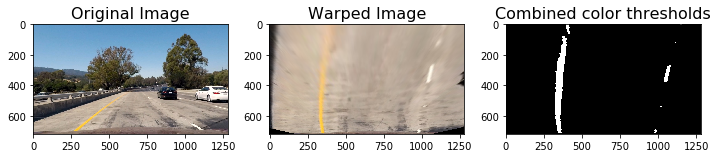

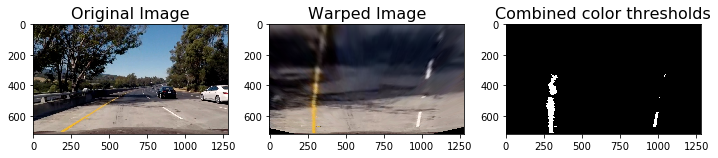

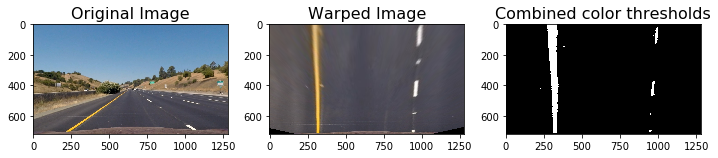

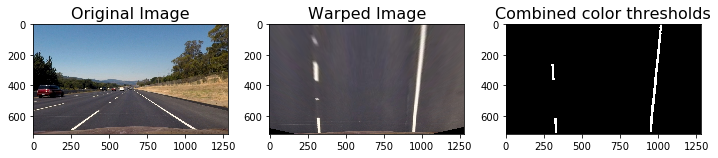

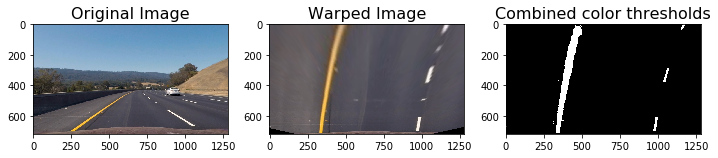

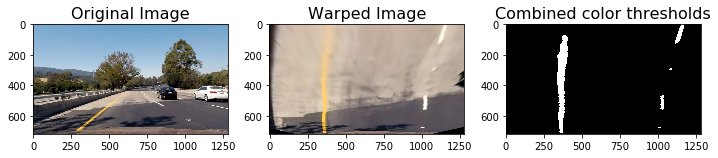

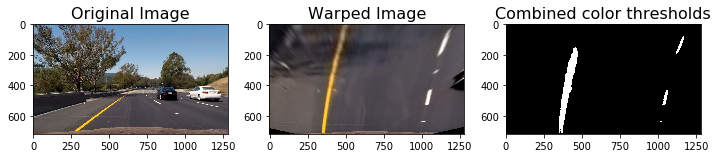

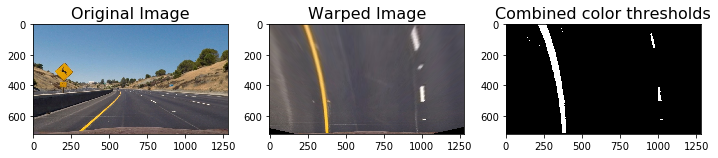

In [6]:
def channel_threshold(channel,channel_thresh):
    channel_binary = np.zeros_like(channel)
    channel_binary[(channel >= channel_thresh[0]) & (channel <= channel_thresh[1])] = 1
    return channel_binary 

def color_thresholds(img, plot):
    pimg, M, Minv = perspective(img, 0)
    #HLS Channels
    HLS_hchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2HLS)[:,:,0]
    HLS_lchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2HLS)[:,:,1]
    HLS_schannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2HLS)[:,:,2]
    #LUV Channels
    LUV_lchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2LUV)[:,:,0]
    LUV_uchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2LUV)[:,:,1]
    LUV_vchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2LUV)[:,:,2]
    #LAB Channels
    LAB_lchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2Lab)[:,:,0]  
    LAB_achannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2Lab)[:,:,1]  
    LAB_bchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2Lab)[:,:,2]  
    #RGB Channels
    RGB_rchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2RGB)[:,:,0]  
    RGB_gchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2RGB)[:,:,1]  
    RGB_bchannel = cv2.cvtColor(pimg, cv2.COLOR_BGR2RGB)[:,:,2]  
    # Threshold color channel
    HLS_hbinary = channel_threshold(HLS_hchannel,(15, 20))
    HLS_sbinary = channel_threshold(HLS_schannel,(90,255))
    LUV_lbinary= channel_threshold(LUV_lchannel,(220,255))
    LAB_bbinary= channel_threshold(LAB_bchannel,(150,210))
    
    combined_binary = np.zeros_like(HLS_sbinary)
    combined_binary[(LUV_lbinary == 1)|(LAB_bbinary == 1)|(HLS_schannel== 1)] = 1

    if plot == 1:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(10,4))
        f.tight_layout()
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image, 0),cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(pimg,cv2.COLOR_BGR2RGB))
        ax3.set_title('Combined color thresholds', fontsize=16)
        ax3.imshow(combined_binary, cmap='gray')

    return combined_binary, pimg, M, Minv
    
    
for image in glob.glob('test_images/*.jpg'):
    color_thresholds(image,1)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

After combining the thresholds and applying them to the perspective transform of the image, the above binary (on the very right) were obtained. These binary images were then used to find the lane lines. In order to find the lane lines the following steps were followed:-

1. Find the histogram along the x axis which describe the peak of active pixels (with the value of 1).
2. Using the histogram, locating the centres of the right and left lane.
3. From the centers forming a sliding window and parsing from the centers to the very top of the image.
4. Using these sliding windows, store the axtivated x and y coordinates of the activated pixels.
5. Fitting a 2nd order polynomial to the stored x and y coordinates of the activated pixels for each of the left and right lanes.


The following code shows how a 2nd order polynomial is fit. This function takes in the image size, x and y coordinates of the acitvated pixels for the left and the right lanes. Performs a polyfit for the function to obtain the A B and C coefficients for a expression Ax^2+ Bx+C. These coefficients are then used to obtain each of the x position for a given y position (plot y) in the image.

In [7]:
def fit_poly(img_size, leftx, lefty, rightx, righty):
    ###Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_size[0]-1, img_size[0])
    #Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx,right_fitx,left_fit,right_fit,ploty



#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in `my_other_file.py`The following code describes the calculation of the radius of curvature. The function takes in the x and y coordinates of the left and right lane activated pixels. It then defines a conversion of x and y pixels to meters in each of the dimensions which then gets used to calculate the radius of the curvature using the 2nd order polynomial. 

In [8]:

def measure_curvature_real(lefty,righty,leftx,rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(lefty)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


The following code describes the pipeline to use an image, apply the color thresholds and perspective transforms, identify the lanes through the sliding window approach and then using the above two functions fitting the polynomial as well us finding the radius of curvature and then filling the lane with color.

In [9]:
def lane_fit(image, plot):
    binary_warped, pimg, M, Minv = color_thresholds(image, 0)
    pimg = cv2.cvtColor(pimg, cv2.COLOR_BGR2RGB)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ###Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ###If you found > minpix pixels, recenter next window ###
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ### (`right` or `leftx_current`) on their mean position ###
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    height_of_image=pimg.shape[0]
    bottom_of_image=0
    img_size=(pimg.shape[0],pimg.shape[1])
    #Extend the lines
    left_fitx,right_fitx,left_fit,right_fit,ploty= fit_poly(img_size, leftx, lefty, rightx, righty)
    rightx_bot = right_fit[0]*height_of_image**2 + right_fit[1]*height_of_image + right_fit[2]
    leftx_bot = left_fit[0]*height_of_image**2 + left_fit[1]*height_of_image + left_fit[2]
    #Measure Radius of Curvature
    left_curverad, right_curverad = measure_curvature_real(lefty,righty,leftx,rightx)
    
    # Calculate the position of the vehicle
    pos = abs(pimg.shape[1]//2 - ((rightx_bot+leftx_bot)//2))
    warp_zero = np.zeros_like(binary_warped)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(255,0,0), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    if plot == 1:
        # Plotting_Display
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(pimg)
        ax1.plot(left_fitx, ploty, color='red', linewidth=4)
        ax1.plot(right_fitx, ploty, color='red', linewidth=4)
        ax1.set_title('Polynomial Fit', fontsize=16)
        ax2.imshow(result)
        ax2.set_title('Area Fit', fontsize=16)
        if pos < pimg.shape[0]/2:
            ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(pos*3.7//700), color='Green', fontsize=12)
        else:
            ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(pos*3.7//700), color='Green', fontsize=12)
        
        ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),color='Green', fontsize=15)
        
    return leftx, lefty, rightx, righty, left_fitx, right_fitx, result    


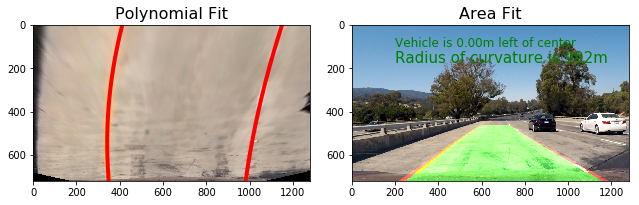

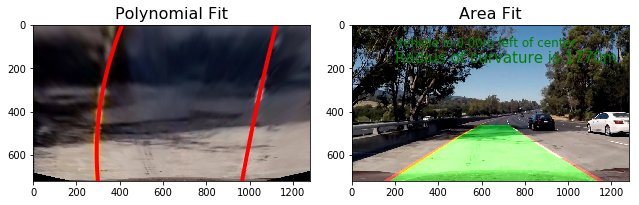

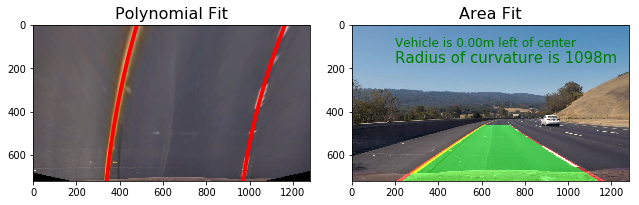

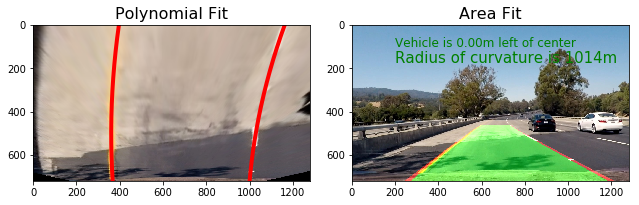

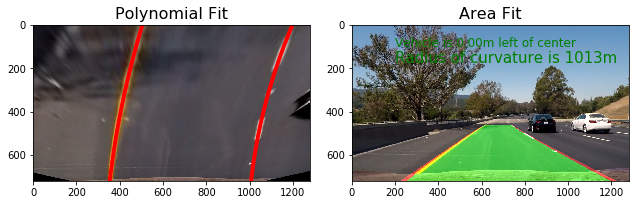

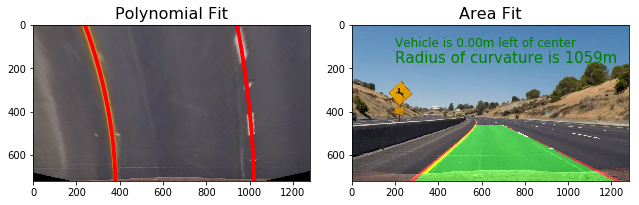

In [10]:
for image in glob.glob('test_images/test*.jpg'):
    leftx, lefty, rightx, righty, left_fit, right_fit, out_img = lane_fit(image,1)

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
As we can see from the above diagrams that the road area is identified clearly and is the lanes are robustly marked on each of the side.

### Video Processing Pipeline

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---



In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

In [12]:
class Line:
    def __init__(self):
        self.detected = False   
        self.X = None
        self.Y = None
        self.cameracalibrated = False
        # Polynomial Coefficients
        self.fit0 = deque(maxlen=20)
        self.fit1 = deque(maxlen=20)
        self.fit2 = deque(maxlen=20)
    
    def lane_fit_usingold(self, x, y,combined_binary):
        xvals = []
        yvals = []
        
        margin = 5

        if self.detected == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - margin) < x)&(x < (xval + margin))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.detected = False 
        return xvals, yvals, self.detected
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    
    def lane_fit_usingnew(self, x, y, image):
        xvals = []
        yvals = []
        margin = 5
        if self.detected == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:500])
                x_idx = np.where((((peak - margin) < x)&(x < (peak + margin))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.detected = True
        else:
            yvals = self.Y
            xvals = self.X
            
        return xvals, yvals, self.detected   
    def lane_radius_of_curvature(self,x,y):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = np.max(y)
        fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
        # Calculation of R_curve (radius of curvature)
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curverad
    
    def fit_poly(self,img_size, x, y):
        ###Fit a second order polynomial to each with np.polyfit() ###
        fit = np.polyfit(y, x, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_size[0]-10, img_size[0])
        #Calc both polynomials using ploty, left_fit and right_fit ###
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        return fit,fitx,ploty
     

In [13]:
run_once = 0
def camera_calibrate(image):
    # Undistort Image
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    run_once =1
    return ret, mtx, dist, rvecs, tvecs

In [14]:
def advanced_channel_threshold(channel,channel_thresh):
    channel_binary = np.zeros_like(channel)
    channel_binary[(channel >= channel_thresh[0]) & (channel <= channel_thresh[1])] = 1
    return channel_binary 

def advanced_color_thresholds(pimg):
    #HLS Channels
    HLS_hchannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2HLS)[:,:,0]
    HLS_lchannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2HLS)[:,:,1]
    HLS_schannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2HLS)[:,:,2]
    #LUV Channels
    LUV_lchannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2LUV)[:,:,0]
    LUV_uchannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2LUV)[:,:,1]
    LUV_vchannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2LUV)[:,:,2]
    #LAB Channels
    LAB_lchannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2Lab)[:,:,0]  
    LAB_achannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2Lab)[:,:,1]  
    LAB_bchannel = cv2.cvtColor(pimg, cv2.COLOR_RGB2Lab)[:,:,2]  
    #RGB Channels
    RGB_rchannel = pimg[:,:,0]  
    RGB_gchannel = pimg[:,:,1]  
    RGB_bchannel = pimg[:,:,2]  
    # Threshold color channel
    HLS_hbinary = advanced_channel_threshold(HLS_hchannel,(15, 20))
    HLS_sbinary = advanced_channel_threshold(HLS_schannel,(90,255))
    LUV_lbinary= advanced_channel_threshold(LUV_lchannel,(220,255))
    LAB_bbinary= advanced_channel_threshold(LAB_bchannel,(150,210))
    
    combined_binary = np.zeros_like(HLS_sbinary)
    combined_binary[(LUV_lbinary == 1)|(LAB_bbinary == 1)|(HLS_sbinary==1)] = 1
    
    return combined_binary

    
def pipeline_video(image):
    img_size = (image.shape[1], image.shape[0])
    
    if run_once == 0:
        ret, mtx, dist, rvecs, tvecs =camera_calibrate(image)
        
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # Perspective transform
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])  
    M = cv2.getPerspectiveTransform(src, dst)
    perspective = cv2.warpPerspective(undist, M, img_size)
    img_size = (perspective.shape[1], perspective.shape[0])
    combined_binary =advanced_color_thresholds(perspective)
    x, y = np.nonzero(np.transpose(combined_binary)) 
    if Left.detected == True:
        leftx, lefty, Left.detected = Left.lane_fit_usingold(x, y,combined_binary)
    if Left.detected == False:
        leftx, lefty, Left.detected = Left.lane_fit_usingnew(x, y, combined_binary)
    if Right.detected == True: 
        rightx, righty, Right.detected = Right.lane_fit_usingold(x, y,combined_binary)  
    if Right.detected == False: 
        rightx, righty, Right.detected = Right.lane_fit_usingnew(x, y, combined_binary) 


    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    left_fit,left_fitx,ploty = Left.fit_poly(img_size, leftx, lefty)
    leftx_bot = left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
    left_top = left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2]
    right_fit,right_fitx,ploty = Right.fit_poly(img_size, rightx, righty)
    rightx_bot = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    right_top = right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2]
    
    
    # Append and sort.
    leftx = np.append(leftx, left_fitx)
    lefty = np.append(lefty, ploty)
    leftx, lefty = Left.sort_vals(leftx, lefty)
    rightx = np.append(rightx, right_fitx)
    righty = np.append(righty, ploty)
    rightx, righty = Right.sort_vals(rightx, righty)
    
    Left.X = leftx
    Left.Y = lefty  
    Right.X = rightx
    Right.Y = righty
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    if  ((abs((2*left_fit[0]+left_fit[1]) -(2*right_fit[0]+right_fit[1]))<=2) & (abs((2*left_fit[0]*720+left_fit[1]) -(2*right_fit[0]*720+right_fit[1]))<=2) & (abs((left_fit[0]*720*720+left_fit[1]*720+left_fit[2]) -(right_fit[0]*720*720+right_fit[1]*720+right_fit[2]))<=800)):
        Left.fit0.append(left_fit[0])
        Left.fit1.append(left_fit[1])
        Left.fit2.append(left_fit[2])
        Right.fit0.append(right_fit[0])
        Right.fit1.append(right_fit[1])
        Right.fit2.append(right_fit[2])
    left_fit = [np.mean(Left.fit0), np.mean(Left.fit1), np.mean(Left.fit2)]    
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

        
    left_curverad = Left.lane_radius_of_curvature(leftx, lefty)
    right_curverad = Right.lane_radius_of_curvature(rightx, righty)

    position = (rightx_bot+leftx_bot)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(255,0,0), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    if position > img_size[1]/2:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(0,255,0), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(0,255,0), thickness = 2)
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(0,255,0), thickness = 2)
    
    return result

In [17]:
Left = Line()
Right = Line()
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [14:31<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [153]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(pipeline_video)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [04:18<00:00,  1.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 3min 34s, sys: 1.35 s, total: 3min 35s
Wall time: 4min 21s


In [154]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))

In [155]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(pipeline_video)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [12:43<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 10min 2s, sys: 3.7 s, total: 10min 6s
Wall time: 12min 47s


In [206]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output3))

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

This was one of the most useful projects I have come across. I spent a lot of time making the pipeline perfect. As of now, it works flawlessly on the project_video.mp4. With some improvements it can also be robust for challenge_video.mp4 

    1. Improve the perspective transform - by increasing the area of interest and the corresponding warped image to get more     lane lines per image shot.
    2. Improvement in color thresholds to capture the shadow effect more robustly.
    3. Making the polynomial of higher order in order to accomodate spline lane curves such as in the harder challenge video
    4. Make the algorithm ignore HOV lane signs keep the fits restricted in terms of changing.

The harder challenge video probably needs the following to get a more robust implementation of the algorithm:-
    1. Higher degree of polynomial fit to accomodate for more manuevering lanes.
    2. Enforce parallel lane lines and maybe use one lane line with higher degree of confidence to map out the other lane line with parallel constraints, curvatures and available pixels of the poorly visible lane.
